# Introduction
- Compare npj results to schrodingers
    - Is the discrepancy due to choice of:
        - Functional?
        - ML-architecture?
- Sam's paper seems to suggest that:
    - MACE is more efficient in terms of data set size requirements,
    - it is possible to generate data with one ML-architecture and train a model with a different ML-architecture on that data and expect similar results, and
    - produces more reliable diffusivities and densities with low seed variability for bulk-models
- Is it possible to train MACE on clusters?
    - This would perhaps allow one to use hybrid functionals
    - We note that the Schrodiger publication had long-range interactions and a different goal than we have here, but we want to see how well it works anyway
    - We should provide examples of studies that focused on neutral systems without excplicit long-range electrostatics with a reasonable degree of success to motivate this further. Just to say something.

# Results and discussion 

In [264]:
from ase.io import read, iread

import matplotlib.pyplot as plt

dynamics_path = '../publication/dynamics/'
static_path = '../publication/static_tests/'

tmap = {
    'npt_000conEC_298K':'EMC (298$\,$K)',
    'npt_033conEC_298K':'EC:EMC (3:7) (298$\,$K)',
    'npt_066conEC_298K':'EC:EMC (7:3) (298$\,$K)',
    'npt_100conEC_313K':'EC (313$\,$K)',
}

In [270]:
def get_all_thermo(tag):
    """This needs to be exhanged for Ioans version in order to be consistent with
    zenodo.
    """
    thermo = {}
    flist = [name for name in glob.glob(tag)]
    #for name in glob.glob(tag):
    #    print(name)
    #flist = z.read_dat_files(tag, ext='.thermo')
    for f in flist:
        #print(f)
        aux = os.path.basename(f)
        key = os.path.splitext(aux)[0]
        #print(aux,key)
        thermo.update({key: pp.loadtxttag(f)})
    return thermo

def get_xyz(tag):
    atoms = {}
    atoms = []
    #print('lol')
    flist = [name for name in glob.glob(tag)]
    #print(flist)
    #for name in glob.glob(tag):
    #    print(name)
    #flist = z.read_dat_files(tag, ext='.thermo')
    for f in flist:
        #print(f)
        if 'xyz' in f:
            return read(f, ':')
    #    aux = os.path.basename(f)
    #    key = os.path.splitext(aux)[0]
    #    print(aux,key)
    #    #atoms.update({key: read(f, ':')})
    #    atoms.append(read(f, ':'))
    #return None

def RMSE(x,ref):
    se = (x-ref)**2
    mse = np.mean(se)
    rmse = mse**0.5
    rrmse = rmse*(np.mean((ref-np.mean(ref))**2))**-0.5
    return rmse, rrmse

## Cluster v. Bulk
We recompute one bulk- and one cluster data set sampled from the full Schrodinger data with B97-D3BJ. We then train two models on each, run dynamics, and compare their results.
### Force correlations and radial distribution
We expect this to look good

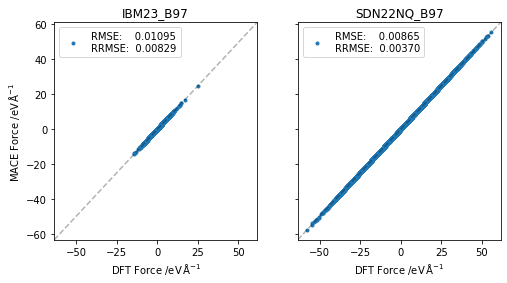

In [ ]:
tags = ['IBM23/B97/SEED1/DSET1', 'SDN22NQ/B97/SEED1/DSET1']#, 'SDN22NQ/B97/SEED1/DSET1'] # These tags needs to be adjusted to be compliant with zenodo

# Obtain data and store to dicts
xyz = dict()
for tag in tags:
    xyz[tag] = get_xyz(f'{static_path}force_correlation/{tag}/*') # Argument should be 'tag' to be consistent with zenodo


fig, axs = plt.subplots(1,2, figsize=(4*2, 4*1), sharex=True, sharey=True)
for i, k in enumerate(xyz):
    tag = tags[i]
    atoms = xyz[k]
    data_set, functional, seed, dset_sample = tag.split('/')
    
    # Obtain forces and errors
    ## reference
    ref_forces = [a.arrays['forces'] for a in atoms if 'forces' in a.arrays.keys()]
    ref_forces = np.concatenate(ref_forces).flatten()

    ## mace
    mace_forces = [a.arrays['MACE_forces'] for a in atoms if 'forces' in a.arrays.keys()]
    mace_forces = np.concatenate(mace_forces).flatten()
    rmse, rrmse = RMSE(mace_forces, ref_forces)

    # Plot correlation    
    axs[i].set_title(f'{data_set}_{functional}')
    axs[i].plot(ref_forces, mace_forces, '.', label=f'RMSE:    {rmse:.5f}\nRRMSE:  {rrmse:.5f}')
    axs[i].legend(loc='upper left', numpoints=1)

    # Plot settings
    axs[i].plot([0, 1], [0, 1], 'k--', transform=axs[i].transAxes, alpha=0.3)
    axs[i].set_xlabel('DFT Force /eV$\,$Å$^{-1}$')
    axs[i].set_xlim([-60,60])
    if i == 0: axs[i].set_ylabel('MACE Force /eV$\,$Å$^{-1}$')


    

### Densities and diffusivites
We see that this comparison looks good

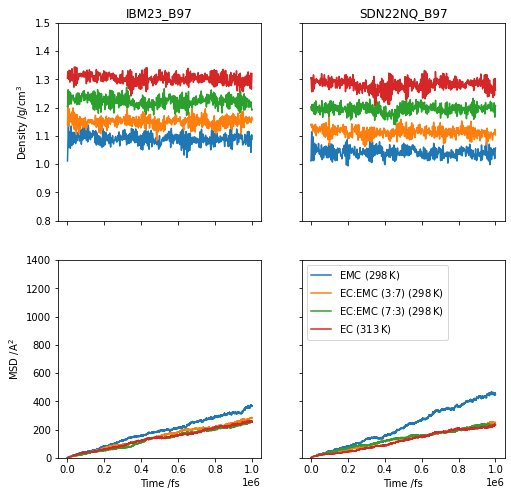

In [271]:
tags = ['IBM23/B97/SEED1/DSET1', 'SDN22NQ/B97/SEED1/DSET1'] # These tags needs to be adjusted to be compliant with zenodo

# Obtain data and store to dicts
thermo = dict()
for tag in tags:
    thermo[tag] = get_all_thermo(f'{dynamics_path}{tag}/*') # Argument should be 'tag' to be consistent with zenodo


fig, axs = plt.subplots(2,2, figsize=(4*2, 4*2), sharex=True, sharey='row')
for i, k in enumerate(thermo):
    tag = tags[i]
    data_set, functional, seed, dset_sample = tag.split('/')
    #print(tag)
    #print(thermo[k].keys())
    for traj_name, traj_data in thermo[k].items():
        # Collect data
        time, tunit = traj_data['Time']['data'], traj_data['Time']['units']
        dens, dunit = traj_data['Density']['data'], traj_data['Density']['units']
        msd, munit = traj_data['MSD']['data'], traj_data['MSD']['units']

        # Plot density
        axs[0,i].set_ylim([0.8, 1.5])
        if i == 0: axs[0,i].set_ylabel(f'Density /{dunit}')
        axs[0,i].plot(time,dens, label=tmap[traj_name])

        # Plot MSD
        axs[1,i].set_ylim([0, 1400])
        if i == 0: axs[1,i].set_ylabel(f'MSD /{munit}')
        axs[1,i].plot(time,msd, label=tmap[traj_name])

        # Shared plot setings
        axs[0,i].set_title(f'{data_set}_{functional}')
        axs[1,i].set_xlabel(f'Time /{tunit}')
axs[-1,-1].legend(loc='upper left')

/tmp/ipykernel_408093/1163979954.py:11: UserWarning:

Attempt to set non-positive ylim on a log-scaled axis will be ignored.



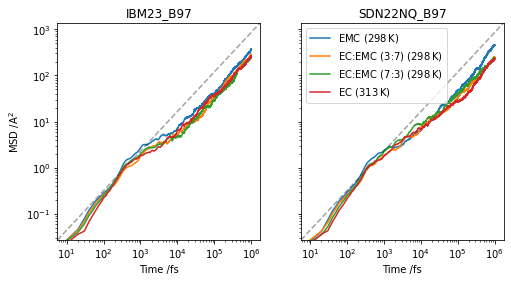

In [275]:
fig, axs = plt.subplots(1,2, figsize=(4*2, 4*1), sharey=True)
for i, k in enumerate(thermo):
    tag = tags[i]
    data_set, functional, seed, dset_sample = tag.split('/')
    for traj_name, traj_data in thermo[k].items():
        # Collect data
        time, tunit = traj_data['Time']['data'], traj_data['Time']['units']
        msd, munit = traj_data['MSD']['data'], traj_data['MSD']['units']

        # Plot MSD
        axs[i].set_ylim([0, 1400])
        if i == 0: axs[i].set_ylabel(f'MSD /{munit}')
        axs[i].plot(time,msd, label=tmap[traj_name])

        # Shared plot setings
        axs[i].plot([0, 1], [0, 1], 'k--', transform=axs[i].transAxes, alpha=0.1)
        axs[i].set_title(f'{data_set}_{functional}')
        axs[i].set_xscale('log'); axs[i].set_yscale('log')
        axs[i].set_xlabel(f'Time /{tunit}')
axs[-1].legend(loc='upper left')

### Data set size optimisation
This is where we show how it all falls apart

### Seed and data set variability

## Possible sources of error
Here we start by doing some data analysis and to look for different correlations between properties etc.

# Other questions and remarks
- Vscans for clusters, bulk and compared to DFT
    - Poor results: shows that this test is not rigorous
    - Good results: shows that this test is perhaps not a good test
- Force-correlations between models
    - Take the trajectories of each models (cluster v. bulk comparison), select a set of snapshot and recompute with B97 and do, for each model, force correlations compared with DFT reference
    - Correlate the two models, independent of DFT reference. Do a triangle-inequality check in force RMSE. Does it say anything?
- IMPORTANT: The schrodinger people systematically sampled structures that were strained or otherwise high in energy in order to have agreement across their QEq-committe. Since this is not of interest to us, it might just be that these structures are inappropriate to train a short-range model on. A different selection might have worked better!
- Check local environments. Take a model independent of any here, such as the MP0 model. Use it to generate fingerprints for the training sets (bulk and cluster) and to t-SNE test to see if they mix or not